In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import transformers
import pandas as pd
import numpy as np
import os
import torch
from sklearn.model_selection import train_test_split
from matplotlib import colors, pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel, RobertaTokenizer, RobertaModel
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from peft import PeftModel, PeftConfig

/home/jovyan/.cache/pypoetry/virtualenvs/nlp-l3iZQJoD-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "1" #0
device = torch.device('cuda:1') # 4 by nvidia-smi
#torch.cuda.set_device('cuda:0')
os.environ['HF_HOME'] = '/home/jovyan/work/artifacts/HF_cache/'

In [3]:
PATH = '/home/jovyan/work/temp/RGS_reviews'
DATA_PATH = os.path.join(PATH, 'geo-reviews-dataset-2023.tskv')

In [4]:
df = pd.read_csv(DATA_PATH, sep='\t', header=None)

In [53]:
df = df.astype('str')

In [54]:
def conv(x):
    if len(x.split('=')) > 1:
        return x.split('=')[1]
    else:
        return x.split('=')[0]

In [55]:
df = df.applymap(conv)

In [56]:
df.columns = ['Address', 'Name', 'Rating', 'Type', 'Text']

In [57]:
def clr(x):
    x = x.split('.')[0]
    if x[0].isdigit():
        return x
    else:
        return ''

In [58]:
df['Rating'] = df['Rating'].apply(clr)

In [60]:
df = df.drop(df.loc[df['Rating'] == ''].index)

In [62]:
df['Rating'] = df['Rating'].astype('int')

In [64]:
df['Type'] = df['Type'].apply(lambda x: x.split(';')[0])

In [66]:
df.to_csv(os.path.join(PATH, 'dataset.csv'), index=False)

In [65]:
df.head()

,Address,Name,Rating,Type,Text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4,Пункт проката,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5,Салон красоты,Топ мастер Ангелина топ во всех смыслах ) Немн...


In [72]:
types = df['Type'].value_counts().to_dict()

In [77]:
selected = list(types.keys())[:200]

In [79]:
selected_df = df[df['Type'].isin(selected)]

In [81]:
selected_df.to_csv(os.path.join(PATH, 'dataset_200.csv'), index=False)

In [105]:
selected2 = list(types.keys())[:10]

In [115]:
selected2_df = df[df['Type'].isin(selected2)]

In [123]:
selected2_df_10k = selected2_df.sample(10000)

In [120]:
selected2_df_10k.to_csv(os.path.join(PATH, 'dataset_10_10000.csv'), index=False)

In [125]:
selected2_df_10k = selected2_df_10k.reset_index(drop=True)

In [129]:
selected2_df_10k['emb'] = ''

## ruRoBERTa

In [5]:
selected2_df_10k = pd.read_csv(os.path.join(PATH, 'dataset_10_10k.csv'))

In [7]:
MODEL = 'sberbank-ai/ruRoberta-large'

In [8]:
tokenizer=RobertaTokenizer.from_pretrained(MODEL)
model = RobertaModel.from_pretrained(MODEL)

Some weights of the model checkpoint at sberbank-ai/ruRoberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at sberbank-ai/ruRoberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to b

In [9]:
model = model.to(device).eval()

In [103]:
%%time
inputs = tokenizer(sample, return_tensors="pt").to(device)
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

CPU times: user 64.1 ms, sys: 38.8 ms, total: 103 ms
Wall time: 108 ms


In [98]:
emb = last_hidden_states[0, 0, :]

In [14]:
for i in tqdm(range(len(selected2_df_10k))):
    text = selected2_df_10k.iloc[i, 4]
    inputs = tokenizer(text, truncation=True, max_length=512,
                       return_tensors="pt").to(device)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    emb = last_hidden_states[0, 0, :]
    emb = list(emb.detach().cpu().numpy())
    emb = ','.join(map(str, emb))
    selected2_df_10k.iloc[i, 5] = emb

100%|██████████| 10000/10000 [08:23<00:00, 19.86it/s]


In [16]:
selected2_df_10k.to_csv(os.path.join(PATH, 'dataset_10_10k.csv'), index=False)

## Анализ

In [44]:
selected2_df_10k = pd.read_csv(os.path.join(PATH, 'dataset_10_10k.csv'))

In [17]:
selected2_df_10k['emb'] = selected2_df_10k['emb'].apply(lambda x: [float(y) for y in x.split(',')])

In [4]:
selected2 = ['Гостиница',
 'Ресторан',
 'Кафе',
 'Супермаркет',
 'Салон красоты',
 'Магазин продуктов',
 'Быстрое питание',
 'Торговый центр',
 'Музей',
 'Бар, паб']

In [5]:
clss = dict(zip( selected2, range(len(selected2))))
clss

{'Гостиница': 0,
 'Ресторан': 1,
 'Кафе': 2,
 'Супермаркет': 3,
 'Салон красоты': 4,
 'Магазин продуктов': 5,
 'Быстрое питание': 6,
 'Торговый центр': 7,
 'Музей': 8,
 'Бар, паб': 9}

In [20]:
X = selected2_df_10k['emb'].to_list()
y = selected2_df_10k['Type'].to_list()

In [21]:
y = [clss[x] for x in y]

<Axes: >

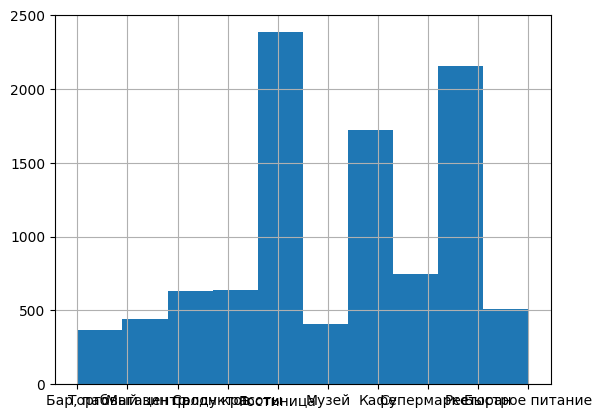

In [22]:
selected2_df_10k['Type'].hist()

In [23]:
# Генерация цветов
colors = plt.cm.prism(np.linspace(0, 0.7, len(selected2)))
# Создание словаря, где каждому элементу списка соответствует цвет
colors = dict(zip(range(len(selected2)), colors))

In [24]:
clrs = [colors[x] for x in y]

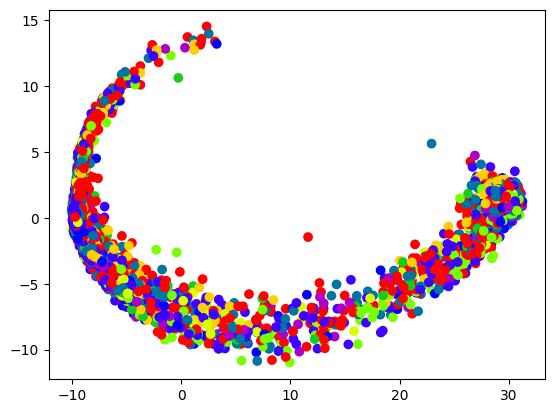

In [26]:
pca = PCA(n_components=2)
embs2 = pca.fit_transform(X)
plt.scatter(embs2[:, 0], embs2[:, 1], c=clrs)

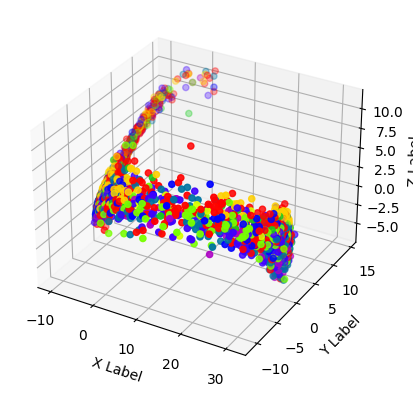

In [27]:
pca = PCA(n_components=3)
embs3 = pca.fit_transform(X)
# Создание трехмерного scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embs3[:, 0], embs3[:, 1], embs3[:, 2], c=clrs)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [29]:
best_acc = 0.0
for metric in ['minkowski', 'cosine']:
    for n_neighbors in range(1, 50):
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        knn.fit(X_train, y_train)
        score = knn.score(X_val, y_val)
        if score > best_acc + 0.01:
            best_acc = score
            best_hparams = {'metric': metric,
                            'n_neighbors': n_neighbors,
                            'accuracy': best_acc}
print(best_hparams)  

{'metric': 'minkowski', 'n_neighbors': 19, 'accuracy': 0.626}


In [30]:
best_acc = 0.0
for n_components in tqdm([1, 2, 3, 4, 5, 8, 16, 32, 64, 128, 256]):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    for metric in ['minkowski', 'cosine']:
        for n_neighbors in range(1, 11):
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
            knn.fit(X_train_pca, y_train)
            score = knn.score(X_val_pca, y_val)
            if score > best_acc + 0.001:
                best_acc = score
                best_hparams = {'n_components': n_components,
                                'metric': metric,
                                'n_neighbors': n_neighbors,
                                'accuracy': best_acc,
                                'best knn': knn}
print(best_hparams)

100%|██████████| 11/11 [01:10<00:00,  6.42s/it]

{'n_components': 256, 'metric': 'minkowski', 'n_neighbors': 9, 'accuracy': 0.63, 'best knn': KNeighborsClassifier(n_neighbors=9)}


## me5

In [31]:
sample = selected2_df_10k.iloc[0, 4]

In [5]:
def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

In [6]:
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large')

In [7]:
model = model.to(device).eval()

In [35]:
# Tokenize the input texts
batch_dict = tokenizer(sample, max_length=512,
                       padding=True, truncation=True,
                       return_tensors='pt').to(device)

outputs = model(**batch_dict)
embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

# normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)

In [41]:
for i in tqdm(range(len(selected2_df_10k))):
    text = selected2_df_10k.iloc[i, 4]
    batch_dict = tokenizer(text, max_length=512,
                           padding=True, truncation=True,
                           return_tensors='pt').to(device)
    outputs = model(**batch_dict)
    emb = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    # normalize embeddings
    emb = F.normalize(emb, p=2, dim=1)
    emb = emb[0,:]
    emb = list(emb.detach().cpu().numpy())
    emb = ','.join(map(str, emb))
    selected2_df_10k.iloc[i, 5] = emb

100%|██████████| 10000/10000 [08:00<00:00, 20.79it/s]


In [43]:
selected2_df_10k.to_csv(os.path.join(PATH, 'dataset_10_10k_me5.csv'), index=False)

## Анализ

In [12]:
selected2_df_10k = pd.read_csv(os.path.join(PATH, 'dataset_10_10k_me5.csv'))

In [46]:
selected2_df_10k['emb'] = selected2_df_10k['emb'].apply(lambda x: [float(y) for y in x.split(',')])

In [6]:
selected2 = ['Гостиница',
 'Ресторан',
 'Кафе',
 'Супермаркет',
 'Салон красоты',
 'Магазин продуктов',
 'Быстрое питание',
 'Торговый центр',
 'Музей',
 'Бар, паб']

In [7]:
clss = dict(zip( selected2, range(len(selected2))))
clss

{'Гостиница': 0,
 'Ресторан': 1,
 'Кафе': 2,
 'Супермаркет': 3,
 'Салон красоты': 4,
 'Магазин продуктов': 5,
 'Быстрое питание': 6,
 'Торговый центр': 7,
 'Музей': 8,
 'Бар, паб': 9}

In [48]:
X = selected2_df_10k['emb'].to_list()
y = selected2_df_10k['Type'].to_list()

In [49]:
y = [clss[x] for x in y]

<Axes: >

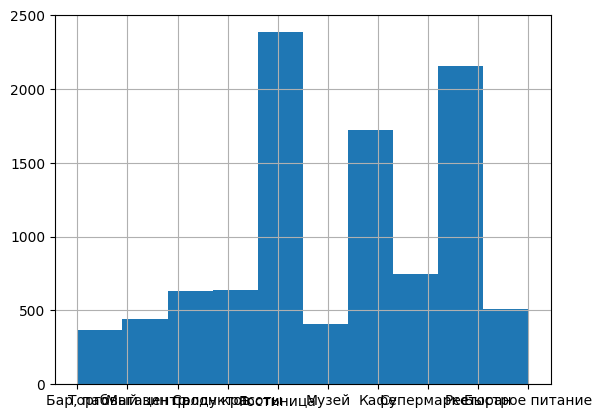

In [50]:
selected2_df_10k['Type'].hist()

In [51]:
# Генерация цветов
colors = plt.cm.prism(np.linspace(0, 0.7, len(selected2)))
# Создание словаря, где каждому элементу списка соответствует цвет
colors = dict(zip(range(len(selected2)), colors))

In [52]:
clrs = [colors[x] for x in y]

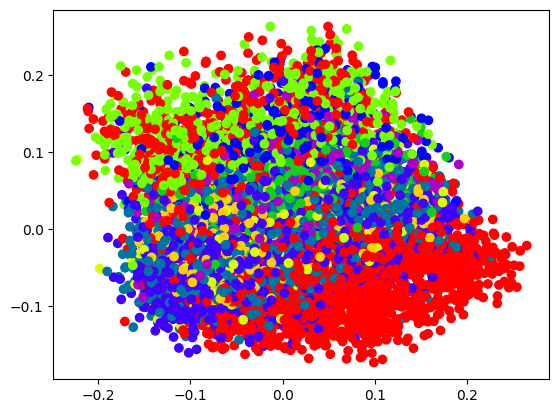

In [53]:
pca = PCA(n_components=2)
embs2 = pca.fit_transform(X)
plt.scatter(embs2[:, 0], embs2[:, 1], c=clrs)

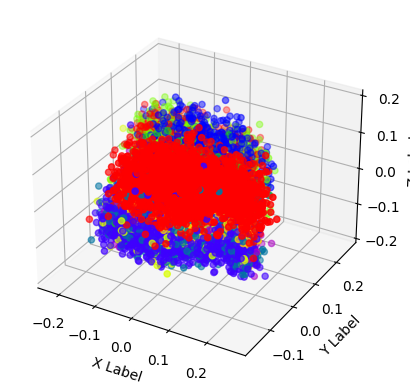

In [54]:
pca = PCA(n_components=3)
embs3 = pca.fit_transform(X)
# Создание трехмерного scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embs3[:, 0], embs3[:, 1], embs3[:, 2], c=clrs)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [56]:
best_acc = 0.0
for metric in ['minkowski', 'cosine']:
    for n_neighbors in range(1, 50):
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        knn.fit(X_train, y_train)
        score = knn.score(X_val, y_val)
        if score > best_acc + 0.01:
            best_acc = score
            best_hparams = {'metric': metric,
                            'n_neighbors': n_neighbors,
                            'accuracy': best_acc}
print(best_hparams)  

{'metric': 'minkowski', 'n_neighbors': 12, 'accuracy': 0.698}


In [57]:
best_acc = 0.0
for n_components in tqdm([1, 2, 3, 4, 5, 8, 16, 32, 64, 128, 256]):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    for metric in ['minkowski', 'cosine']:
        for n_neighbors in range(1, 11):
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
            knn.fit(X_train_pca, y_train)
            score = knn.score(X_val_pca, y_val)
            if score > best_acc + 0.001:
                best_acc = score
                best_hparams = {'n_components': n_components,
                                'metric': metric,
                                'n_neighbors': n_neighbors,
                                'accuracy': best_acc,
                                'best knn': knn}
print(best_hparams)

100%|██████████| 11/11 [01:03<00:00,  5.74s/it]

{'n_components': 128, 'metric': 'cosine', 'n_neighbors': 10, 'accuracy': 0.705, 'best knn': KNeighborsClassifier(metric='cosine', n_neighbors=10)}


## me5 'query-passage' method

In [14]:
df_data = []
for k, v in tqdm(clss.items()):
    batch_dict = tokenizer(f"passage: {k}", max_length=512,
                           padding=True, truncation=True,
                           return_tensors='pt').to(device)
    outputs = model(**batch_dict)
    emb = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    # normalize embeddings
    emb = F.normalize(emb, p=2, dim=1)
    emb = emb[0,:]
    emb = list(emb.detach().cpu().numpy())
    emb = ','.join(map(str, emb))
    df_data.append({'Type': k, 'Class': v, 'emb': emb})

100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


In [15]:
types_df = pd.DataFrame(df_data)
types_df

,Type,Class,emb
0,Гостиница,0,"0.02835512,-0.008552394,-0.022115136,-0.032541..."
1,Ресторан,1,"0.027402371,-0.007339362,-0.022758927,-0.02273..."
2,Кафе,2,"0.044338886,-0.01046975,-0.010085001,-0.019978..."
3,Супермаркет,3,"0.031440176,-0.019280382,-0.010278794,-0.03218..."
4,Салон красоты,4,"0.0155575955,0.0017925804,-0.031970084,-0.0462..."
5,Магазин продуктов,5,"0.04045583,-0.025052987,-0.014782952,-0.041842..."
6,Быстрое питание,6,"0.030955406,0.0045409156,0.001866644,-0.029515..."
7,Торговый центр,7,"0.034252822,-0.025081584,-0.027064387,-0.02545..."
8,Музей,8,"0.01791489,-0.037110627,-0.017962195,-0.015792..."
9,"Бар, паб",9,"0.044229496,0.011488459,-0.034052275,-0.021212..."


In [16]:
types_df.to_csv(os.path.join(PATH, 'types_10_me5.csv'), index=False)

In [17]:
for i in tqdm(range(len(selected2_df_10k))):
    text = selected2_df_10k.iloc[i, 4]
    batch_dict = tokenizer(f"query: {text}", max_length=512,
                           padding=True, truncation=True,
                           return_tensors='pt').to(device)
    outputs = model(**batch_dict)
    emb = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    # normalize embeddings
    emb = F.normalize(emb, p=2, dim=1)
    emb = emb[0,:]
    emb = list(emb.detach().cpu().numpy())
    emb = ','.join(map(str, emb))
    selected2_df_10k.iloc[i, 5] = emb

100%|██████████| 10000/10000 [09:41<00:00, 17.20it/s]


In [18]:
selected2_df_10k.to_csv(os.path.join(PATH, 'dataset_10_10k_me5_q.csv'), index=False)

## Анализ

In [6]:
selected2_df_10k = pd.read_csv(os.path.join(PATH, 'dataset_10_10k_me5_q.csv'))

In [7]:
types_df = pd.read_csv(os.path.join(PATH, 'types_10_me5.csv'))

In [8]:
selected2_df_10k['emb'] = selected2_df_10k['emb'].apply(lambda x: [float(y) for y in x.split(',')])

In [9]:
types_df['emb'] = types_df['emb'].apply(lambda x: [float(y) for y in x.split(',')])

In [13]:
types_list = types_df['emb'].to_list()

In [10]:
type_matrix = np.array(types_list)

In [23]:
acc = []
for i in range(len(selected2_df_10k)):
    emb = np.array(selected2_df_10k.iloc[i, 5])[np.newaxis, :]
    score = type_matrix @ emb.T
    gt = clss[selected2_df_10k.iloc[i, 3]]
    pred = score.argmax()
    acc.append(gt == pred) 

In [24]:
accuracy = np.array(acc).mean()
print(accuracy)

0.5766


## LLMs

In [26]:
print({v: k for k, v in clss.items()})

{0: 'Гостиница', 1: 'Ресторан', 2: 'Кафе', 3: 'Супермаркет', 4: 'Салон красоты', 5: 'Магазин продуктов', 6: 'Быстрое питание', 7: 'Торговый центр', 8: 'Музей', 9: 'Бар, паб'}


In [14]:
i = 4
print(selected2_df_10k.iloc[i, 4])
print(selected2_df_10k.iloc[i, 3])

Мастер хорошо сделала брови. Результат ее работы держится до сих пор. \nИ еще пара приятных бонусов: принесли очень вкусный травяной чай в отдельном чайничке и подарили соль для ванночек для маникюра.
Салон красоты


Выбери из следующего списка: 
{0: 'Гостиница', 1: 'Ресторан', 2: 'Кафе', 3: 'Супермаркет', 4: 'Салон красоты', 5: 'Магазин продуктов', 6: 'Быстрое питание', 7: 'Торговый центр', 8: 'Музей', 9: 'Бар, паб'} ,
к какой категории относится следующий отзыв клиента:
Раньше это было одно из самых любимых мест! Сегодня у вас были 5-ый раз, все по прежнему чисто, уютно, атмосферно, но есть большое НО…..РЕСТОРАН….это просто ужас, после дороги, прогулки, решили поужинать, подошли к нам принять заказ минимум через 20 минут, суп-лапша просто ужасный на вкус(цена 300₽, как в ресторане в Москве, на вкус, как в больничной столовой), все остальное есть было можно на 3+, в уборной комнате было очень грязно, мокрый и грязный пол с разбросанными салфетками. А теперь о самом неприятном моменте, мы проживали в двоем с мужем в большом номере(т.е. где подразумевается проживание и питание на 4-ых), завтрак мы заказали естественно на двоих, в котором указали овсяную кашу, на что нам ответили, что надо уточнять, какая каша будет утром в ресторане. Мы ответили, что если будет гречневая- мы ее не едим и попросили яичницу с томатами. На самом деле, на завтрак была гречневая каша, и нам отказались готовить яичницу, объяснив это ошибкой администратора, мы попросили выяснить этот момент, но к нам больше никто не подошёл… если такое отношение и дальше будет к гостям, вы их просто растеряете…. Так же нам принесли две порции блинов (которые были холодные) на одной тарелке, это как, надо было есть по очереди? Извините, но это ресторан, и подача должна хоть немного соответствовать.
Выведи только номер категории.


In [19]:
# LLM Saiga-Mistral и полезные функции для работы с этой моделью
MODEL_NAME = "IlyaGusev/saiga_mistral_7b_lora"
DEFAULT_MESSAGE_TEMPLATE = "<s>{role}\n{content}</s>"
DEFAULT_RESPONSE_TEMPLATE = "<s>bot\n"
DEFAULT_SYSTEM_PROMPT = """Ты — Сайга, помогаешь определять, к какой категории
относится предприятие, о котором оставил отзыв клиент. Выбери из следующего списка: 
{0: 'Гостиница', 1: 'Ресторан', 2: 'Кафе', 3: 'Супермаркет', 4: 'Салон красоты',
5: 'Магазин продуктов', 6: 'Быстрое питание', 7: 'Торговый центр', 8: 'Музей', 9: 'Бар, паб'}.
Выведи в ответе только номер категории, которой соответствует отзыв.""" 

class Conversation:
    def __init__(
        self,
        message_template=DEFAULT_MESSAGE_TEMPLATE,
        system_prompt=DEFAULT_SYSTEM_PROMPT,
        response_template=DEFAULT_RESPONSE_TEMPLATE
    ):
        self.message_template = message_template
        self.response_template = response_template
        self.messages = [{
            "role": "system",
            "content": system_prompt
        }]

    def add_user_message(self, message):
        self.messages.append({
            "role": "user",
            "content": message
        })

    def add_bot_message(self, message):
        self.messages.append({
            "role": "bot",
            "content": message
        })

    def get_prompt(self, tokenizer):
        final_text = ""
        for message in self.messages:
            message_text = self.message_template.format(**message)
            final_text += message_text
        final_text += DEFAULT_RESPONSE_TEMPLATE
        return final_text.strip()


def generate(model, tokenizer, prompt, generation_config):
    data = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
    data = {k: v.to(model.device) for k, v in data.items()}
    output_ids = model.generate(
        **data,
        generation_config=generation_config
    )[0]
    output_ids = output_ids[len(data["input_ids"][0]):]
    output = tokenizer.decode(output_ids, skip_special_tokens=True)
    return output.strip()

config = PeftConfig.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map=device #"auto"    
)
#model = model.to(device)
model = PeftModel.from_pretrained(
    model,
    MODEL_NAME,
    torch_dtype=torch.float16,
    #device_map={'': 0}
)
#model = model.to(device).eval()
model.eval()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)

Loading checkpoint shards: 100%|██████████| 2/2 [00:32<00:00, 16.31s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [28]:
def step(inp, meta='', prnt=True):
    if meta == '':
        system_prompt = DEFAULT_SYSTEM_PROMPT
    else:
        system_prompt =  meta
    сonversation = Conversation(system_prompt=system_prompt)   
    сonversation.add_user_message(inp)
    prompt = сonversation.get_prompt(tokenizer)
    output = generate(model, tokenizer, prompt, generation_config)
    if prnt:
        print(inp)
        print(output)
        print("==============================")
    return(output)

In [21]:
prompt = """Мастер хорошо сделала брови. Результат ее работы держится до сих пор. \nИ еще пара приятных бонусов: принесли очень вкусный травяной чай в отдельном чайничке и подарили соль для ванночек для маникюра."""

In [22]:
%%time
step(prompt)

Мастер хорошо сделала брови. Результат ее работы держится до сих пор. 
И еще пара приятных бонусов: принесли очень вкусный травяной чай в отдельном чайничке и подарили соль для ванночек для маникюра.
4
CPU times: user 2.73 s, sys: 511 ms, total: 3.24 s
Wall time: 3.27 s


'4'

In [29]:
acc = []
for i in tqdm(range(1000)):
    try:
        prompt = selected2_df_10k.iloc[i, 4]
        gt = int(clss[selected2_df_10k.iloc[i, 3]])
        pred = int(step(prompt, prnt=False))
        acc.append(gt == pred)
    except Exception as e:
        print(e)
        continue
accuracy = np.array(acc).mean()
print(accuracy)

  1%|          | 10/1000 [00:26<1:00:13,  3.65s/it]

invalid literal for int() with base 10: '7: Торговый центр'


 14%|█▎        | 136/1000 [05:06<51:17,  3.56s/it] 

invalid literal for int() with base 10: "8: 'Музей'"


 51%|█████     | 507/1000 [18:38<23:40,  2.88s/it]

invalid literal for int() with base 10: '8: Музей'


100%|██████████| 1000/1000 [35:36<00:00,  2.14s/it]

0.4102306920762287


## Metric learning

In [ ]:
from transformers import pipeline

extractor = pipeline(model="google-bert/bert-base-uncased", task="feature-extraction")
result = extractor("This is a simple test.", return_tensors=True)
result.shape  # This is a tensor of shape [1, sequence_lenth, hidden_dimension] representing the input string.
torch.Size([1, 8, 768])